In [1]:
import cv2
import json
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
def load_json(json_file):
    with open(str(json_file), 'r') as f:
        preds = json.load(f)
    return preds

In [3]:
data_dir = Path('../data/test/')
json_dir = Path('../submit/')

subset = 'a'
#names = ['submit_det_yolov4_a9_retail_one_200_emb_resnet50_mlp_loc_retail_50_top_1', 'submit_det_yolov4_a9_retail_one_200_emb_resnet50_mlp_loc_retail_50_top_5']
names = ['output', 'output']
dets_models = []
for name in names:
    json_file = json_dir / '{}.json'.format(name)
    preds = load_json(json_file)
    preds['model_name'] = name
    dets_models.append(preds)

In [4]:
# load categories from reference set
ref_json_file = data_dir / 'b_annotations.json'
refs = load_json(ref_json_file)
categories = refs['categories']

num_classes = len(categories)
classes = []
class_ids = []
for category in categories:
    classes.append(category['name'])
    class_ids.append(category['id'])

class_ids = np.array(class_ids)
CLASSES = np.array(classes)

In [5]:
def get_detections(index, subset, dets):
    img_info = dets['images'][index]
    img_name = img_info['file_name']
    img_id = img_info['id']
    img_path = data_dir / '{}_images'.format(subset) / img_name
    
    bbox_list = []
    score_list = []
    cls_list = []
    for det in dets['annotations']:
        if det['image_id'] == img_id:
            bbox = det['bbox']
            cls_id = det['category_id']
            score = det.get('score', 0.0)
            bbox_list.append(bbox)
            cls_list.append(cls_id)
            score_list.append(score)
    return {'img_path': img_path, 'bbox_list': bbox_list, 'score_list': score_list, 'cls_list': cls_list}

In [6]:
def get_product_annotation(index, refs):
    imgs_ref = refs['images']
    img_path = ''
    for img_info in imgs_ref:
        img_id = img_info['id']
        if img_id == index:
            img_name = img_info['file_name']
            img_path = data_dir / 'b_images' / img_name
            break
    
    if img_path == '':
        print('Product image with index {} not found'.format(index))
        return
    
    bbox_list = []
    cls_list = []
    for gt in refs['annotations']:
        if gt['image_id'] == index:
            bbox = gt['bbox']
            cls_id = gt['category_id']
            bbox_list.append(bbox)
            cls_list.append(cls_id)
    return {'img_path': img_path, 'bbox_list': bbox_list, 'cls_list': cls_list}

In [7]:
np.random.seed(1234)
colors = np.random.randint(0, 255, size=(CLASSES.shape[0], 3), dtype=np.uint8)
plt.rcParams['figure.figsize'] = [14, 7]

In [8]:
def show_detection(img_index, subset, dets_models, show_score_thr = 0.0,show_score=True):
    fig, ax = plt.subplots(1, len(dets_models))
    
    for model_id, dets in enumerate(dets_models):
        det_dict = get_detections(img_index, subset, dets)
        img_path = det_dict['img_path']
        bbox_list = det_dict['bbox_list']
        score_list = det_dict['score_list']
        cls_list = det_dict['cls_list']
        
        img = cv2.imread(str(img_path))
        for i, bbox in enumerate(bbox_list):
            score = score_list[i]
            if score < show_score_thr:
                continue
                
            x1, y1, w, h = bbox
            cls_id = cls_list[i]
            color = colors[cls_id].tolist()
            cv2.rectangle(img, (x1, y1), (x1+w, y1+h), color, 3)
            cls_name = CLASSES[cls_id]
            cv2.putText(img, cls_name, (x1+10, y1 + 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
            
            if show_score:
                cv2.putText(img, '{:.2f}'.format(score), (int(x1 + w/2) - 10, int(y1 + h / 2)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
        cv2.putText(img, '{}'.format(img_index), (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
        ax[model_id].set_title(dets['model_name'])
        ax[model_id].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[model_id].set_xticks([])
        ax[model_id].set_yticks([])
    
    plt.tight_layout()
    plt.show()

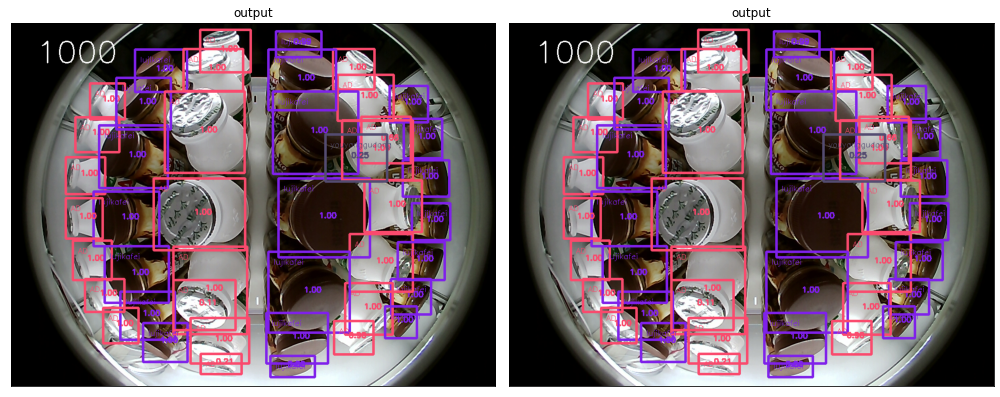

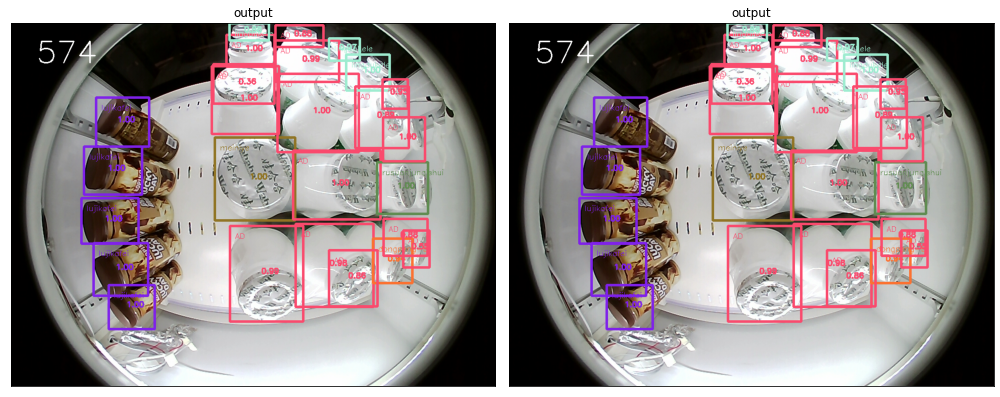

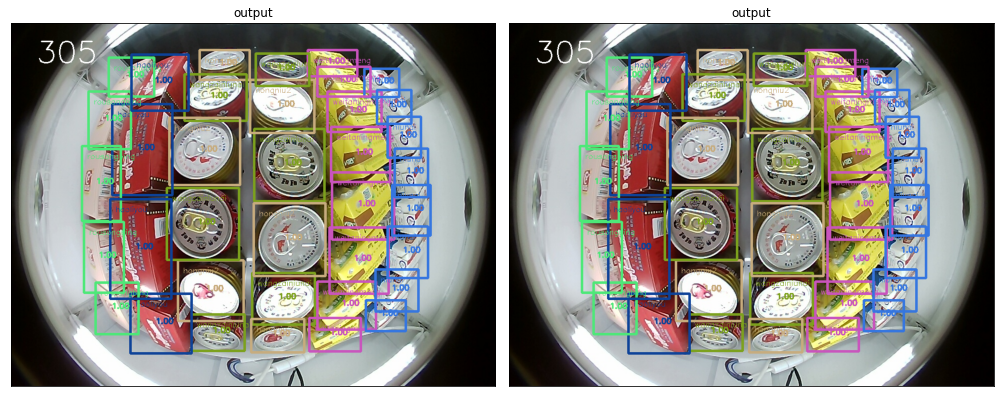

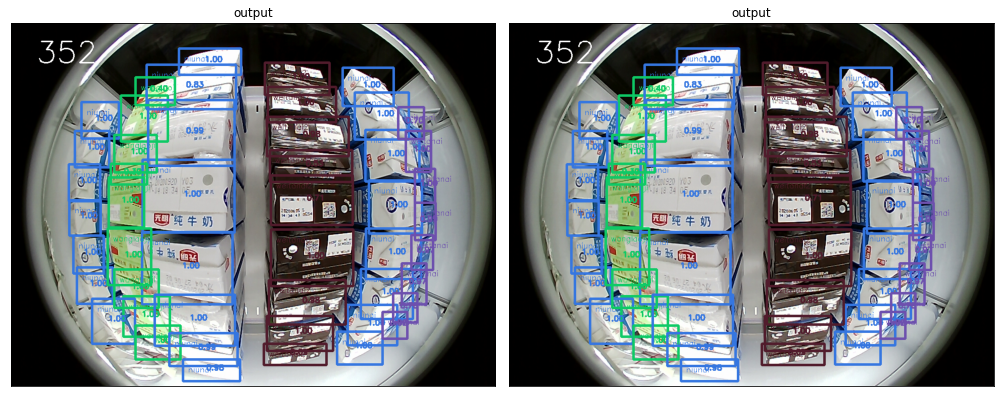

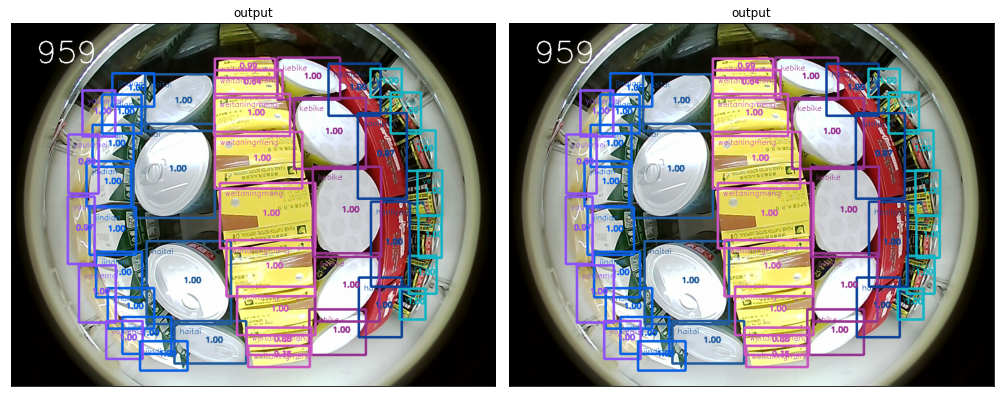

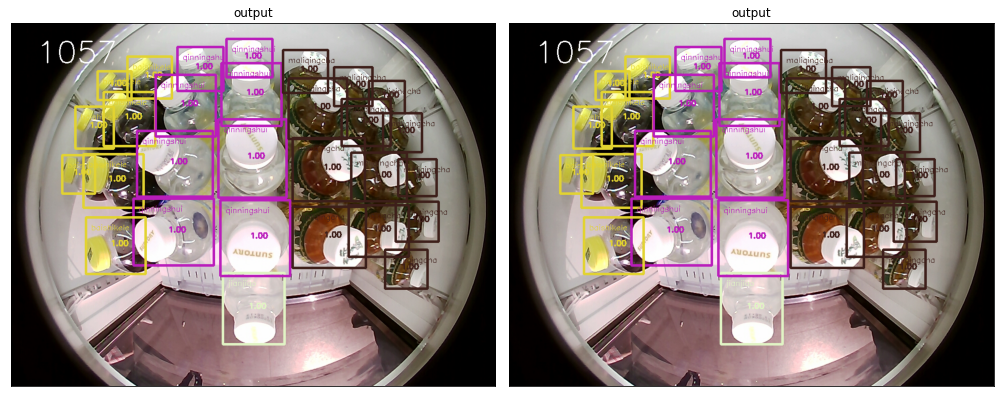

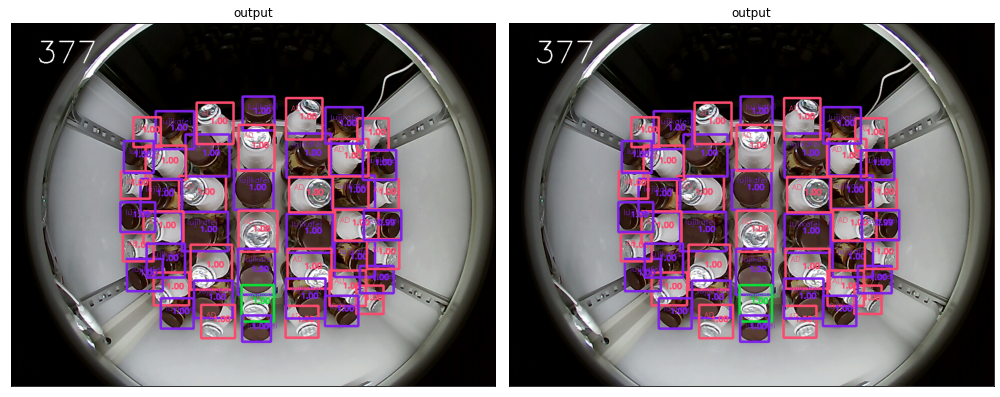

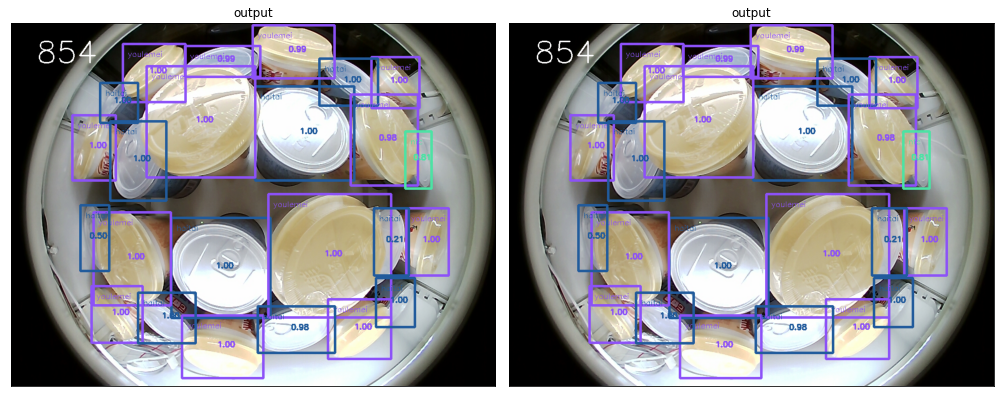

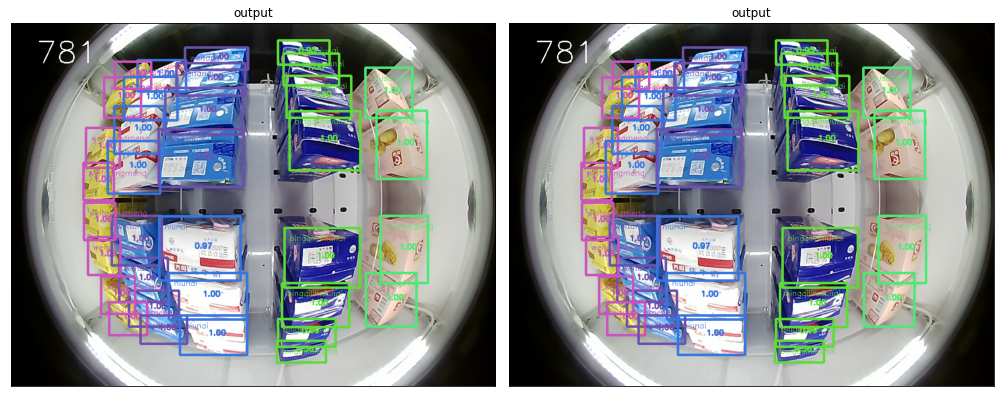

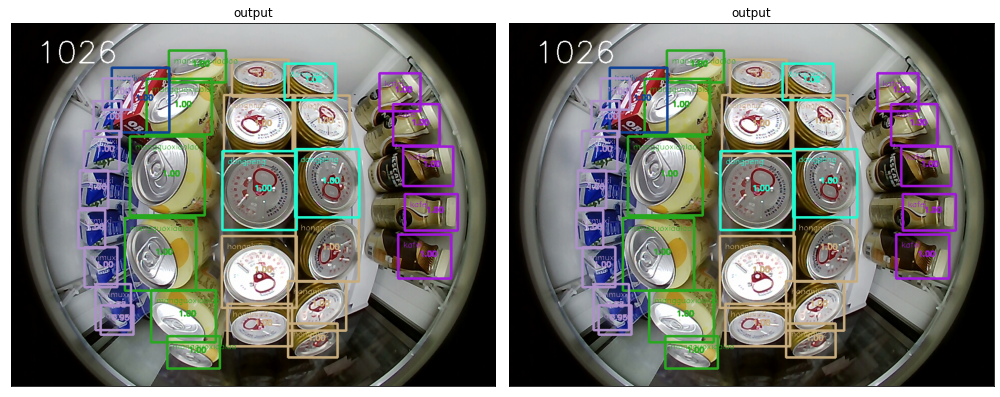

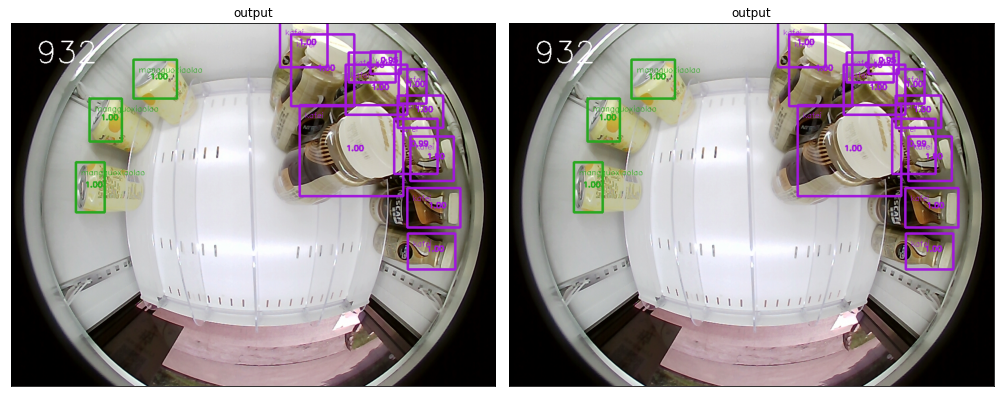

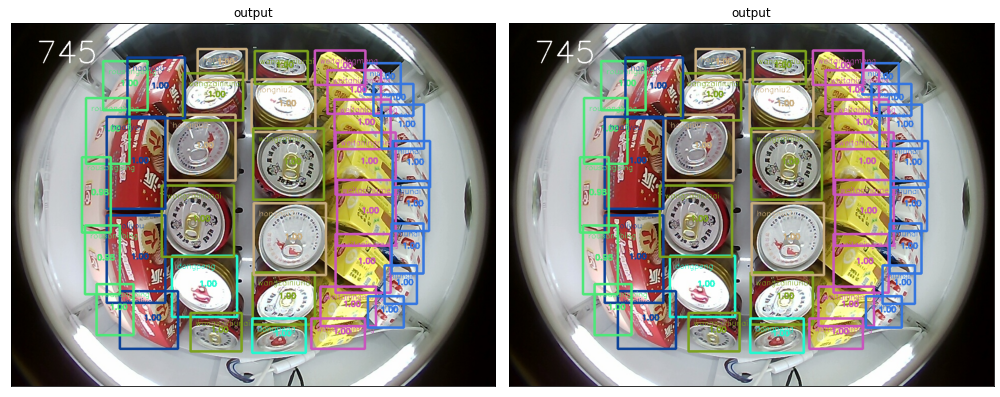

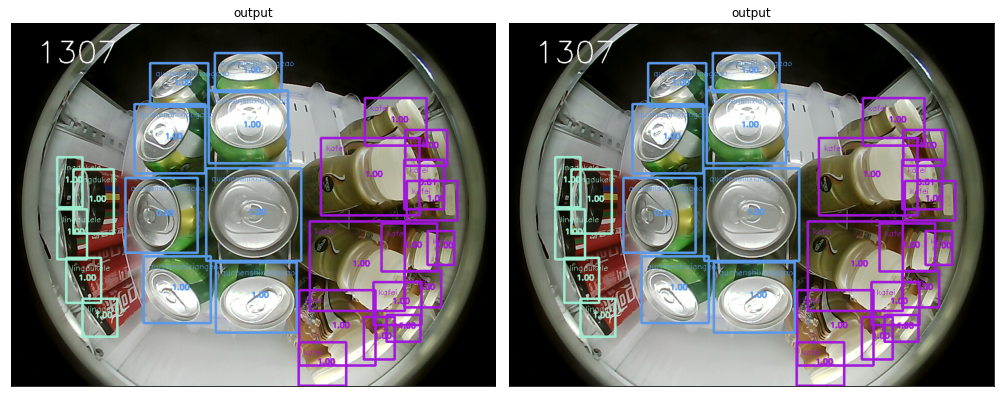

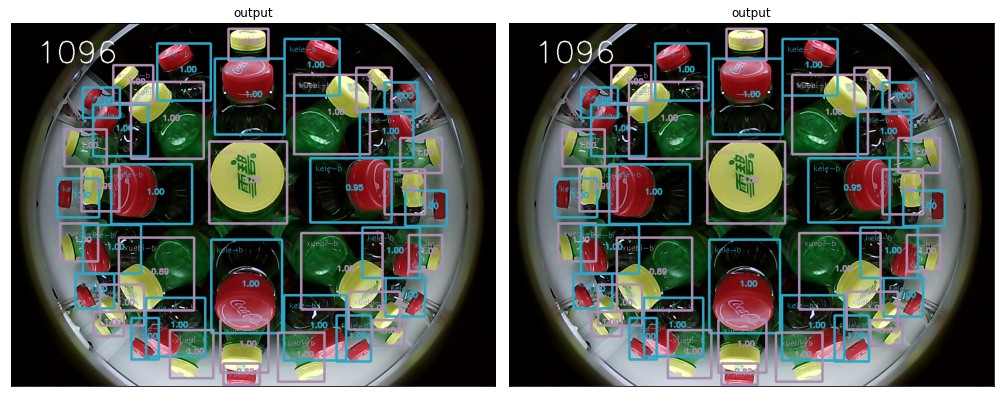

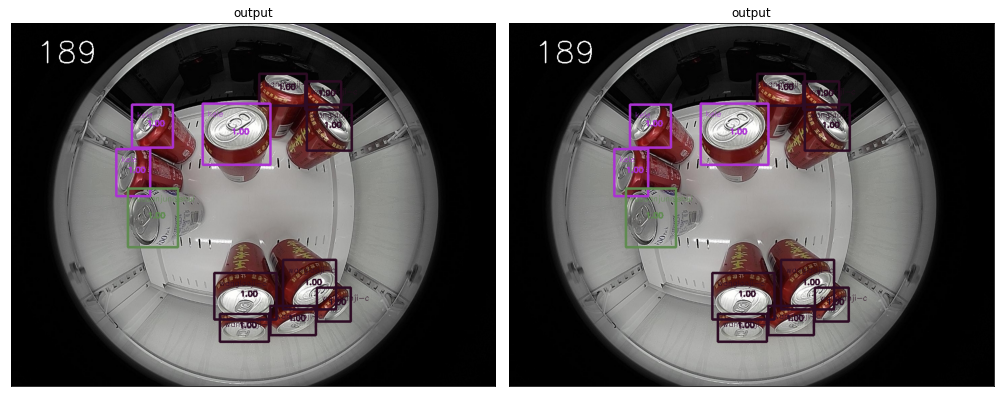

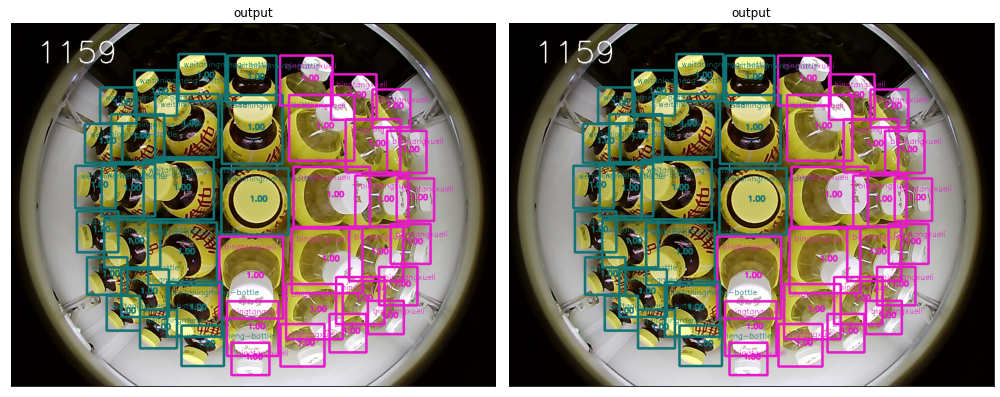

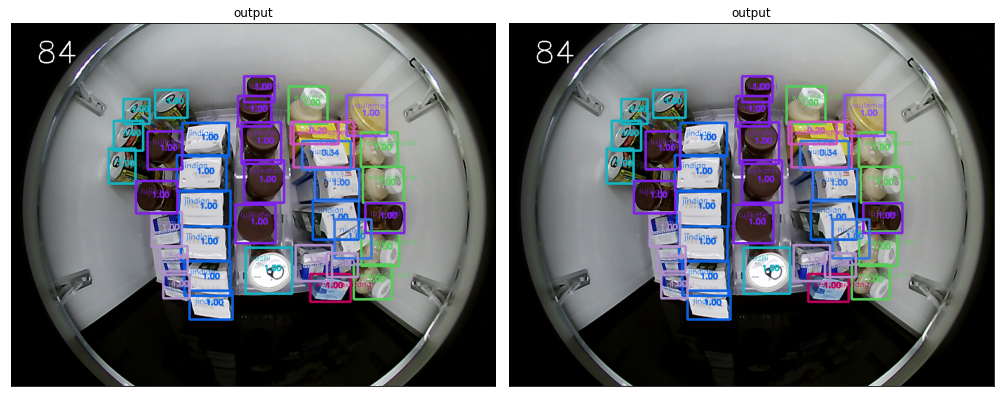

In [9]:
for idx in [1000, 574, 305, 352, 959, 1057, 377, 854, 781, 1026, 932, 745, 1307, 1096, 189, 1159, 84]:
    show_detection(idx, subset, dets_models, show_score_thr = 0.0)

In [10]:
def show_products(product_ids, refs):
    for cls_id in product_ids:
        img_id = product_ids[cls_id]
        gt_dict = get_product_annotation(img_id, refs)
        img_path = gt_dict['img_path']
        bbox_list = gt_dict['bbox_list']
        cls_list = gt_dict['cls_list']
        img = cv2.imread(str(img_path))
        for i, bbox in enumerate(bbox_list):
            cls_id = cls_list[i]
            cls_name = classes[cls_id]
            x1, y1, w, h = bbox
            color = colors[cls_id].tolist()
            cv2.rectangle(img, (x1, y1), (x1+w, y1+h), color, 3)
            cv2.putText(img, cls_name, (x1+10, y1 + 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()

In [11]:
def find_products_with_class(cls_ids_example, refs):
    product_ids = {}
    for ann in refs['annotations']:
        cls_id = ann['category_id']
        img_id = ann['image_id']
        if cls_id in cls_ids_example and cls_id not in product_ids:
            product_ids[cls_id] = img_id
    return product_ids

1110


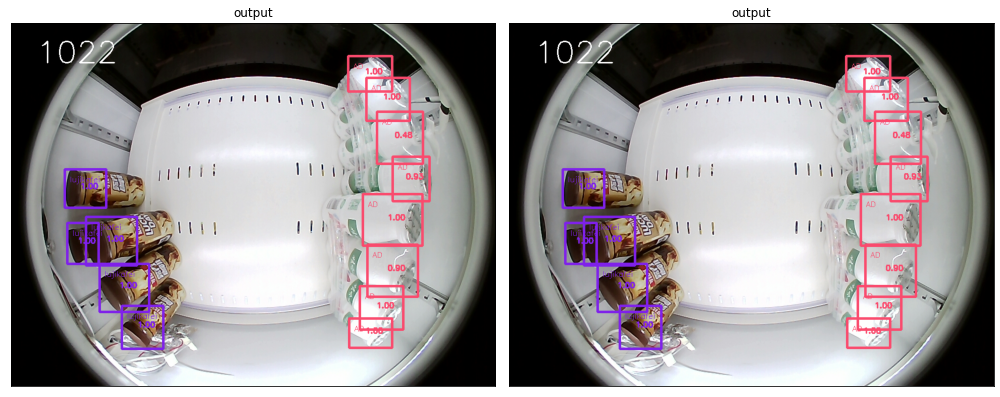

In [12]:
num_images = len(dets_models[0]['images'])
idx = np.random.randint(num_images)
print(idx)
show_detection(1022, subset, dets_models, show_score_thr = 0.1)
#product_ids = find_products_with_class(cls_ids_example)
#show_products(product_ids)